In [48]:
# Based on https://github.com/GoogleCloudPlatform/ml-design-patterns/blob/master/03_problem_representation/rebalancing.ipynb.
#   !gsutil cp gs://ml-design-patterns/fraud_data_kaggle.csv .

import xgboost as xgb
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras

In [89]:
SEED = 42
NROWS = 100000

def process_data(df: pd.DataFrame) -> pd.DataFrame:
    df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'], inplace=True)
    df = pd.get_dummies(df)

    target = df.isFraud
    df = df.drop(columns=['isFraud'])
    sc = StandardScaler()    
    df[df.columns] = sc.fit_transform(df)
    df['isFraud'] = target
    return df

def fraud_rate_df(df: pd.DataFrame) -> float:
    fraud_df = df[df['isFraud'] == 1]
    return len(fraud_df)/len(df)

def fraud_rate(y) -> float:
    fraud_indices = np.where(y == 1)[0]
    return len(fraud_indices) / len(y) # type: ignore

def train_split(df: pd.DataFrame):
    y = df.isFraud.values
    X_train, X_test, _, y_test = train_test_split(df, y, stratify=y, test_size=0.2, random_state=SEED)
    train_df = pd.DataFrame(data=X_train, columns=df.columns)
    X_test.drop(columns=['isFraud'], inplace=True) # type: ignore
    return train_df, X_test, y_test

# This is from the sklearn docs
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.3f}',
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()  
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def train_and_eval(df: pd.DataFrame, should_down_sample: bool=False, frac: float=1.0, use_class_weight=False):

    train_df, X_test, y_test = train_split(df)

    # down_sample
    if should_down_sample:
        print(f"Down sample train {frac}")
        fraud = train_df[train_df['isFraud'] == 1]
        not_fraud = train_df[train_df['isFraud'] == 0]
        not_fraud_sample = not_fraud.sample(random_state=SEED, frac=frac)
        train_df = pd.concat([not_fraud_sample,fraud])
        train_df = shuffle(train_df, random_state=SEED)    
    else:
        print("Original train")

    X_train = train_df.drop(columns=['isFraud']).values
    y_train = train_df.isFraud.values

    print(f'Fraud Rate in (all, train, test)=({fraud_rate_df(df):.5f}, {fraud_rate(y_train):.5f}, {fraud_rate(y_test):.5f})')

    if use_class_weight:
        minor_weight = 1 / fraud_rate(y_train) / 2
        major_weight = 1 / (1 - fraud_rate(y_train)) / 2
        class_weight = {1: minor_weight, 0: major_weight}
    else:
        class_weight = None

    model = keras.Sequential([
        keras.layers.Dense(10, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])    
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    model.fit(X_train, y_train, epochs=2, batch_size=512, verbose=0, class_weight=class_weight)

    y_pred = model.predict(X_test)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.reshape(-1).astype(int)
    print(f'label={y_test} pred={y_pred}')
    print(f'accuracy_score: {accuracy_score(y_test, y_pred):.4f}')    
    print(f'precision_score: {precision_score(y_test, y_pred):.4f}')
    print(f'recall_score: {recall_score(y_test, y_pred):.4f}')    
    print(f'f1_score: {f1_score(y_test, y_pred):.4f}')
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    print('cm', cm, cm.ravel())
    tn, fp, fn, tp = cm.ravel()
    print(f'tp={tp} fn={fn} fp={fp} tn={tn}')
    print(f'precision={tp/(tp+fp)}')
    classes = ['not fraud', 'fraud']    
    plot_confusion_matrix(cm, classes, normalize=False)    

In [90]:
df = pd.read_csv('/kaggle/input/fraud_data_kaggle.csv', nrows=NROWS)
df = process_data(df)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,-4.108186,-0.475641,-0.264702,-0.270632,-0.366533,-0.422519,-0.502889,-0.665865,-0.099893,1.237286,-0.306685,0
1,-4.108186,-0.498805,-0.320397,-0.322604,-0.366533,-0.422519,-0.502889,-0.665865,-0.099893,1.237286,-0.306685,0
2,-4.108186,-0.503694,-0.328278,-0.329753,-0.366533,-0.422519,-0.502889,-0.665865,-0.099893,-0.808221,3.260669,1
3,-4.108186,-0.503694,-0.328278,-0.329753,-0.357715,-0.422519,-0.502889,1.501806,-0.099893,-0.808221,-0.306685,1
4,-4.108186,-0.470330,-0.312802,-0.318731,-0.366533,-0.422519,-0.502889,-0.665865,-0.099893,1.237286,-0.306685,0


Original train
Fraud Rate in (all, train, test)=(0.00116, 0.00116, 0.00115)


2021-11-29 19:51:33.903146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-29 19:51:35.145997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[0 0 0 ... 0 0 0]
accuracy_score: 0.9989
precision_score: 0.0000
recall_score: 0.0000
f1_score: 0.0000
cm [[1. 0.]
 [1. 0.]] [1. 0. 1. 0.]
tp=0.0 fn=1.0 fp=0.0 tn=1.0
precision=nan


/Users/higepon/miniforge3/envs/kaggle-vent/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/wm/b5d2qft111vgdzrhrny8hx0w0000gn/T/ipykernel_47630/741296189.py:106: RuntimeWarning: invalid value encountered in double_scalars
  print(f'precision={tp/(tp+fp)}')


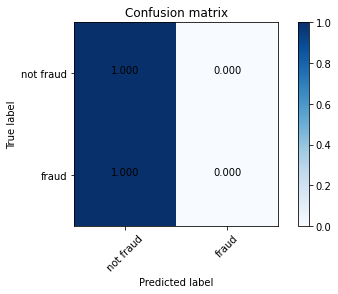

In [91]:
# Use the imblanced train data as is.
train_and_eval(df)

Original train
Fraud Rate in (all, train, test)=(0.00116, 0.00116, 0.00115)


2021-11-29 19:51:35.857006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-29 19:51:37.063199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[0 0 1 ... 0 0 0]
accuracy_score: 0.7113
precision_score: 0.0038
recall_score: 0.9565
f1_score: 0.0076
cm [[0.71096761 0.28903239]
 [0.04347826 0.95652174]] [0.71096761 0.28903239 0.04347826 0.95652174]
tp=0.9565217391304348 fn=0.043478260869565216 fp=0.28903238724533215 tn=0.7109676127546679
precision=0.7679487537917441


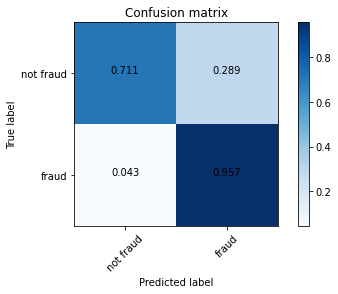

In [92]:
# Based on the isFraud rate, we pass class_weight to Keras.
train_and_eval(df, use_class_weight=True)

Down sample train 0.0001
Fraud Rate in (all, train, test)=(0.00116, 0.92079, 0.00115)


2021-11-29 19:51:37.773575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-29 19:51:37.867693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[0 0 1 ... 1 1 0]
accuracy_score: 0.4466
precision_score: 0.0012
recall_score: 0.5652
f1_score: 0.0023
cm [[0.44651349 0.55348651]
 [0.43478261 0.56521739]] [0.44651349 0.55348651 0.43478261 0.56521739]
tp=0.5652173913043478 fn=0.43478260869565216 fp=0.5534865094859088 tn=0.4465134905140912
precision=0.5052430682552158


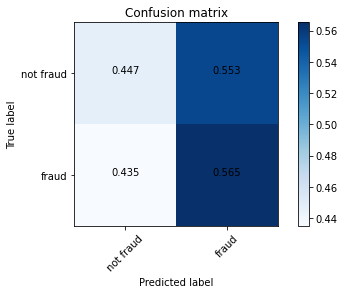

In [93]:
# We down sample the train data.
train_and_eval(df, should_down_sample=True, frac=0.0001)

Down sample train 0.003
Fraud Rate in (all, train, test)=(0.00116, 0.27928, 0.00115)


2021-11-29 10:51:37.047318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-29 10:51:37.142657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[1 0 0 ... 0 0 0]
accuracy_score: 0.62
precision_score: 0.00
recall_score: 0.00
f1_score: 0.00
tp=0 fn=12466 fp=7511 tn=23
precision=0.0


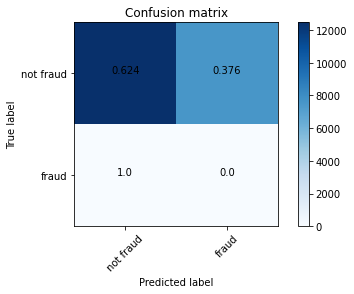

In [65]:
# We down sample the train data.
train_and_eval(df, should_down_sample=True, frac=0.003)

Down sample train 0.002
Fraud Rate in (all, train, test)=(0.00116, 0.36759, 0.00115)


2021-11-29 10:07:01.881927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-29 10:07:01.988386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[1 0 1 ... 0 0 0]
f1_score: 0.00


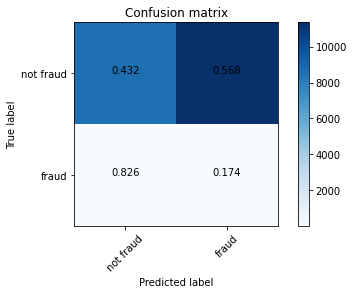

In [43]:
# We down sample the train data.
train_and_eval(df, should_down_sample=True, frac=0.002)

Down sample train 0.001
Fraud Rate in (all, train, test)=(0.00116, 0.53757, 0.00115)


2021-11-29 10:07:02.902981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-29 10:07:02.997356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[0 0 0 ... 0 0 0]
f1_score: 0.00


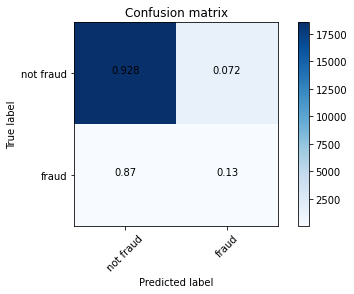

In [44]:
# We down sample the train data.
train_and_eval(df, should_down_sample=True, frac=0.001)

Down sample train 0.002
Fraud Rate in (all, train, test)=(0.00116, 0.36759, 0.00115)


2021-11-29 10:07:03.864642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-29 10:07:03.956487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[0 0 0 ... 0 0 0]
f1_score: 0.00


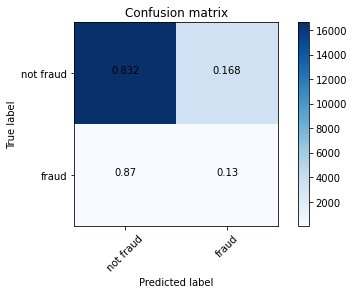

In [45]:
# We first down sample the train data, then also use the class_weight.
train_and_eval(df, should_down_sample=True, frac=0.002, use_class_weight=True)